In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df= pd.read_csv(r'C:\Users\shikh\OneDrive\Desktop\Datasets\heart.csv')

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
X = df.drop(columns=['target'])
y = df['target']
print(X.shape)
print(y.shape)

(303, 13)
(303,)


In [5]:
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(x_train.shape)
print(x_test.shape)

(227, 13)
(76, 13)


First we will fit a normal decision tree without any fine tuning and check the results

In [6]:
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(x_train,y_train)
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

In [7]:
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()

Train score 1.0
Test score 0.8289473684210527
Train Confusion matrix


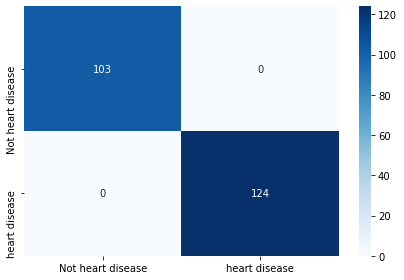

Test Confusion matrix


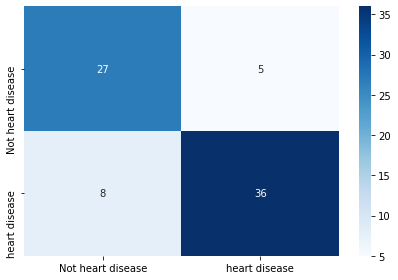

In [8]:
classes = ['Not heart disease','heart disease']
print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

# 1. Pre pruning

In [9]:
params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2]}

clf = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(x_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

Train score 0.8810572687224669
Test score 0.7236842105263158
Train Confusion matrix


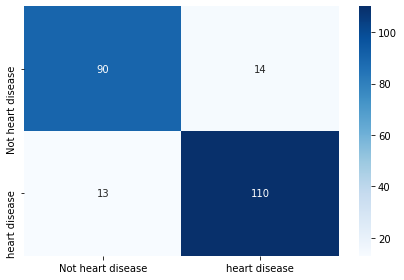

Test Confusion matrix


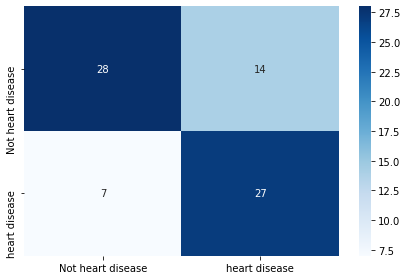

In [10]:
model = gcv.best_estimator_
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

# 2. Post pruning techniques

Cost Complexity Pruning

In [11]:
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00396476 0.0041116  0.00414615 0.00425338 0.00429784
 0.00431718 0.00528634 0.00533097 0.00660793 0.00660793 0.00734214
 0.00737094 0.00753686 0.00755192 0.00755192 0.00850327 0.01006923
 0.01048878 0.0139127  0.0145493  0.0154185  0.03041037 0.03499774
 0.04462127 0.13455478]


In [12]:
# For each alpha we will append our model to a list
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)

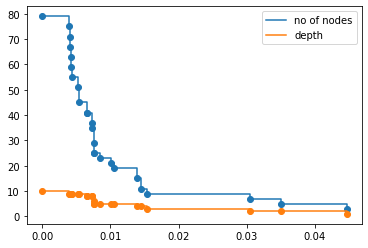

In [13]:
#We will remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node.
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

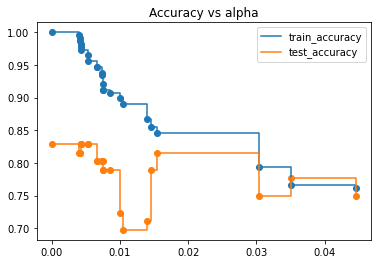

In [14]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(x_train)
    y_test_pred = c.predict(x_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

Train score 0.8458149779735683
Test score 0.8157894736842105
Train Confusion matrix


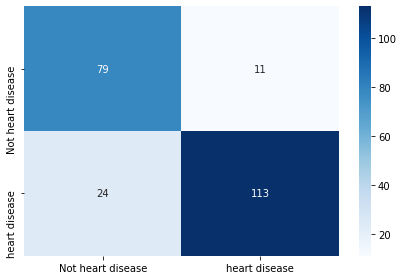

Test Confusion matrix


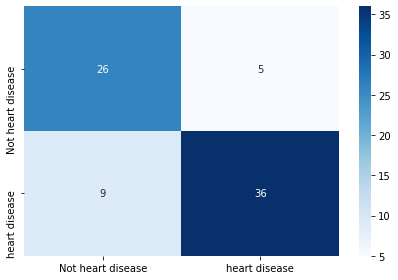

In [15]:
clf_ = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.020)
clf_.fit(x_train,y_train)
y_train_pred = clf_.predict(x_train)
y_test_pred = clf_.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')